In [2]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


## Import Necessary Libraries
Ensure all necessary libraries are imported:

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# To ignore warinings
import warnings
warnings.filterwarnings('ignore')


2024-08-06 15:30:59.377956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 15:30:59.378046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:30:59.504450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define Paths and Parameters
Set up the paths and parameters:

In [3]:
# Load the dataset
train_dir = '/kaggle/input/cassava-leaf-disease-classification/train'
test_dir = '/kaggle/input/cassava-leaf-disease-classification/test'

In [4]:
batch_size = 32
img_size = (224, 224)
num_classes = len(os.listdir(train_dir)) # Ensure this correctly counts the number of class folders

In [5]:
num_classes

5

## Data Preprocessing
Set up data preprocessing and augmentation:

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(test_dir,
                                                        target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
                                                       )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 14552 images belonging to 5 classes.
Found 639 images belonging to 5 classes.
Found 4280 images belonging to 5 classes.


## Build the MobileNetV2 Model
Build the MobileNetV2 model:

In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train the Model
Train the model:

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
     callbacks=[early_stopping]
   
)

Epoch 1/10
  1/455 ━━━━━━━━━━━━━━━━━━━━ 2:16:01 18s/step - accuracy: 0.1562 - loss: 1.7447

I0000 00:00:1722958894.152655     172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722958894.184628     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/455 ━━━━━━━━━━━━━━━━━━━━ 3:33 641ms/step - accuracy: 0.6064 - loss: 1.1532

W0000 00:00:1722958971.689879     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.6443 - loss: 1.0133

W0000 00:00:1722959173.275609     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


455/455 ━━━━━━━━━━━━━━━━━━━━ 315s 654ms/step - accuracy: 0.6444 - loss: 1.0129 - val_accuracy: 0.6886 - val_loss: 0.8352
Epoch 2/10


W0000 00:00:1722959190.882933     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


455/455 ━━━━━━━━━━━━━━━━━━━━ 206s 445ms/step - accuracy: 0.7087 - loss: 0.8161 - val_accuracy: 0.6823 - val_loss: 0.8630
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 205s 445ms/step - accuracy: 0.7090 - loss: 0.7935 - val_accuracy: 0.7167 - val_loss: 0.8167
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 205s 444ms/step - accuracy: 0.7256 - loss: 0.7630 - val_accuracy: 0.7183 - val_loss: 0.7899
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 207s 448ms/step - accuracy: 0.7206 - loss: 0.7570 - val_accuracy: 0.7199 - val_loss: 0.7781
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 205s 444ms/step - accuracy: 0.7269 - loss: 0.7366 - val_accuracy: 0.7121 - val_loss: 0.7735
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 205s 443ms/step - accuracy: 0.7393 - loss: 0.7162 - val_accuracy: 0.7027 - val_loss: 0.8070
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 208s 449ms/step - accuracy: 0.7344 - loss: 0.7251 - val_accuracy: 0.7277 - val_loss: 0.7513
Epoch 9/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 204s 442ms/step - accuracy: 0.7332 - loss: 0.72

## Evaluate the Model
Evaluate the model and calculate the accuracy on the test set:

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

134/134 ━━━━━━━━━━━━━━━━━━━━ 43s 319ms/step - accuracy: 0.5716 - loss: 1.1067
Test Loss: 0.7928
Test Accuracy: 0.7056


W0000 00:00:1722961083.243406     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Plot Loss and Accuracy Graphs
Plot the training and validation loss and accuracy graphs:

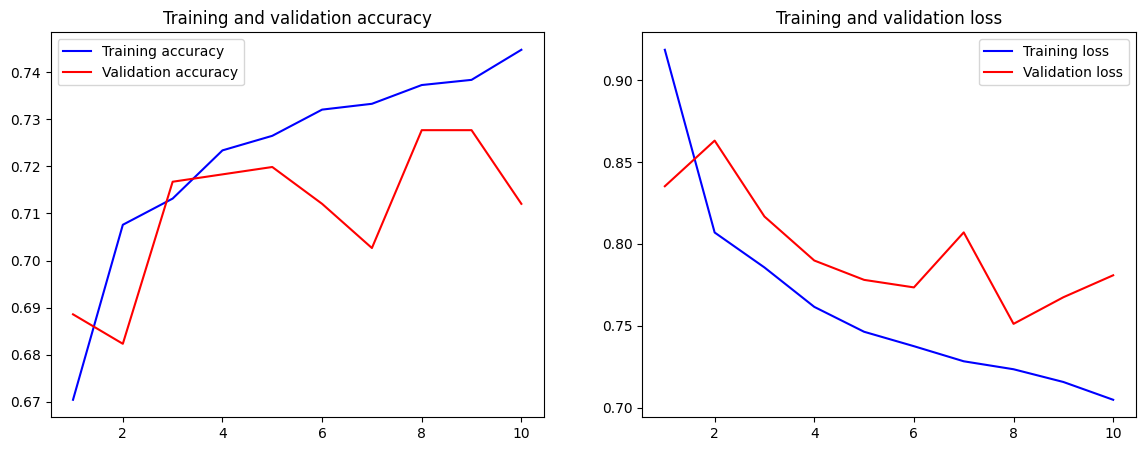

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Print classification report and plot confusion matrix

  3/134 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step

W0000 00:00:1722961235.593183     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 159ms/step


W0000 00:00:1722961256.747492     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.47      0.39      0.43       217
Cassava Brown Streak Disease (CBSD)       0.61      0.42      0.49       438
         Cassava Green Mottle (CGM)       0.46      0.37      0.41       477
       Cassava Mosaic Disease (CMD)       0.84      0.86      0.85      2632
                            Healthy       0.43      0.62      0.51       516

                           accuracy                           0.71      4280
                          macro avg       0.56      0.53      0.54      4280
                       weighted avg       0.71      0.71      0.70      4280



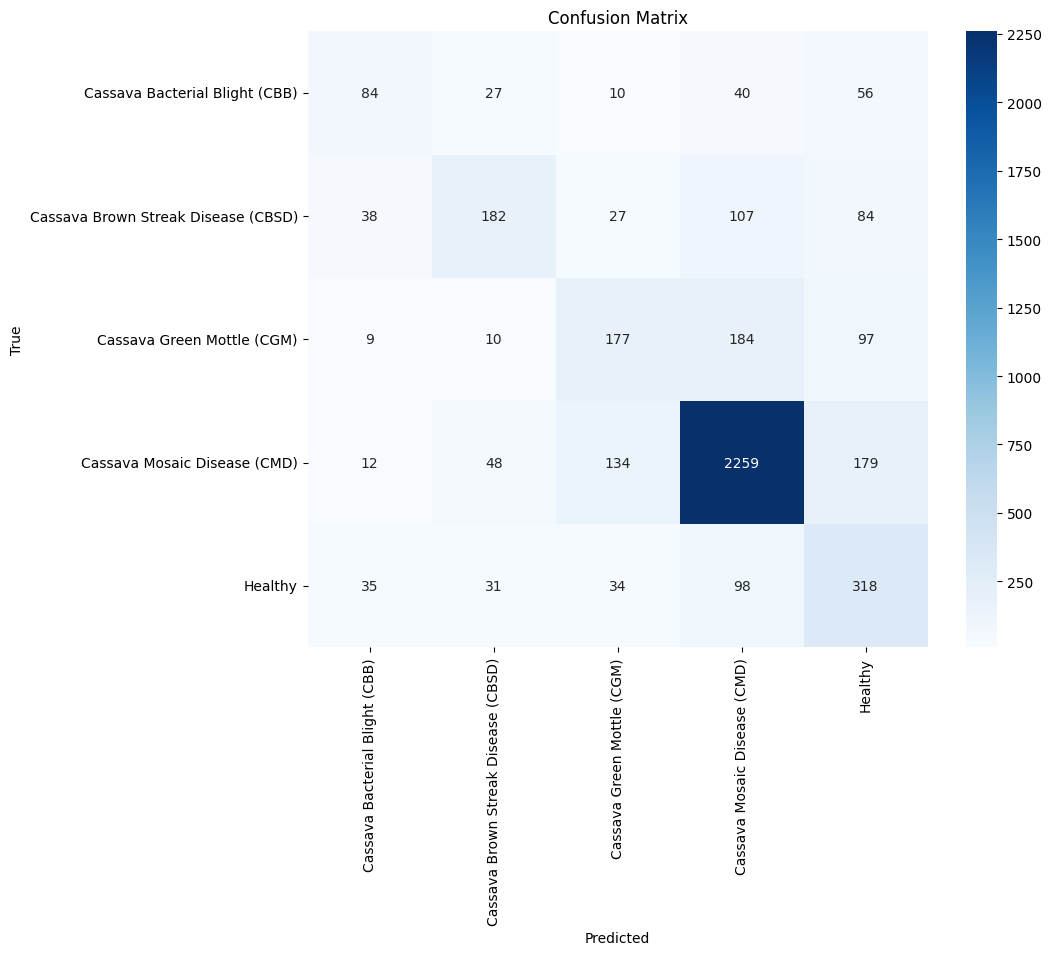

In [13]:
# Get the ground truth labels and predicted labels
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Display sample images with true and predicted labels

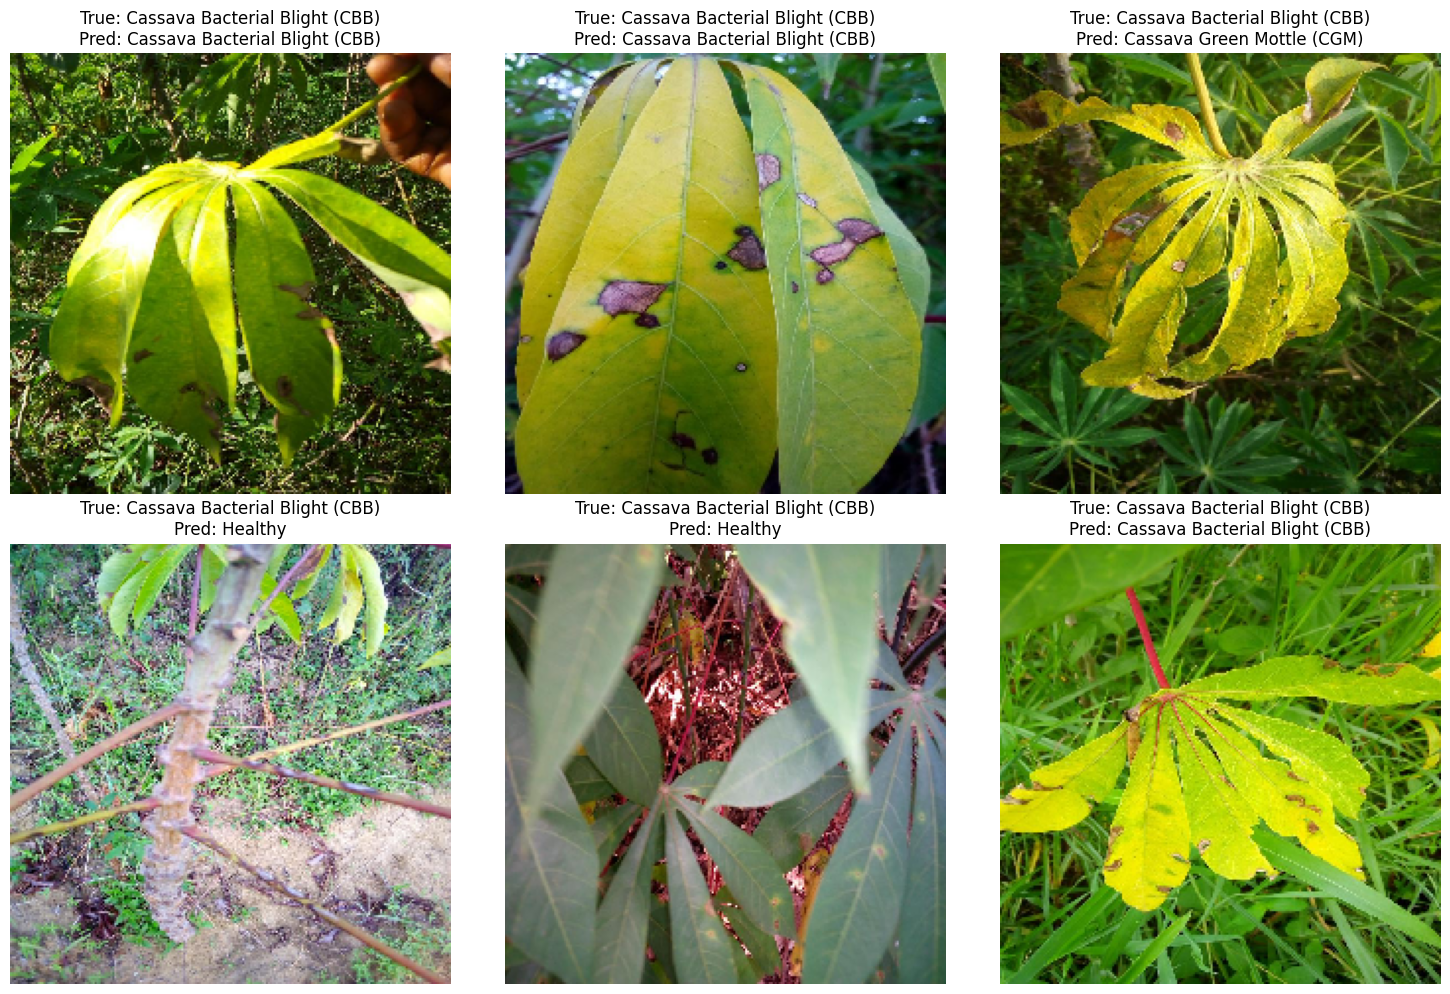

In [14]:
# Display sample images with true and predicted labels
def show_sample_images_with_predictions(generator, true_labels, predicted_labels, class_labels, num_samples=6):
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 10))
    axes = axes.flatten()
    for img, ax, true_label, pred_label in zip(generator[0][0][:num_samples], axes, true_labels[:num_samples], predicted_labels[:num_samples]):
        img = (img * 255).astype(np.uint8)  # Reverse normalization for display
        ax.imshow(img)
        ax.set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Show sample images
show_sample_images_with_predictions(test_generator, y_true, y_pred, class_labels)